# Using python to explore Wikipedia pageview data for all current members of the U.S. Congress

By Stuart Geiger (@staeiou, User:Staeiou), licensed under the MIT license

Did you know that Wikipedia has been tracking aggregate, anonymized, hourly data about the number of times each page is viewed? There are [data dumps](http://stats.grok.se/), an [API](https://wikitech.wikimedia.org/wiki/Analytics/PageviewAPI), and a [web tool](https://tools.wmflabs.org/pageviews/?project=en.wikipedia.org&platform=all-access&agent=user&range=latest-20&pages=Cat|Dog) for exploring small sets of pages (see [this blog post](https://blog.wikimedia.org/2015/12/14/pageview-data-easily-accessible/) for more on those three). In this notebook, I show how to use python to get data on hundreds of pages at once -- every current member of the U.S. Senate and House of Representatives.

## Libraries

We're using mwviews for getting the pageview data, pandas for the dataframe, and seaborn/matplotlib for plotting. pywikibot is in here because I tried to use it to get titles programmatically, but gave up.

In [1]:
!pip install mwviews pywikibot seaborn pandas

In [2]:
import mwviews
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)

## Data

The .txt files are manually curated lists of titles, based on first copying and pasting the columns displaying the names of the members of Congress at 
[List_of_United_States_Senators_in_the_115th_Congress_by_seniority](http://enwp.org/List_of_United_States_Senators_in_the_115th_Congress_by_seniority) and [List_of_United_States_Representatives_in_the_115th_Congress_by_seniority](http://enwp.org/List_of_United_States_Representatives_in_the_115th_Congress_by_seniority). Then each of the article links was manually examined to make sure they match the linked page, and updated if, for example, the text said "Dan Sullivan" but the article was at "Dan Sullivan (U.S. Senator)". Much thanks to [Amy Johnson](http://web.mit.edu/hasts/graduate/johnson.html) who helped curate these lists.

I tried programmatically getting lists of all current members of Congress, my failed attempts can be found at the end.


The files have one title per line, so we read it in and split it into a list with ```.split("\n")```

In [3]:
with open("senators.txt") as f:
    sen_txt = f.read()

sen_list = sen_txt.split("\n")

In [4]:
sen_list[0:5]

['Richard Shelby',
 'Luther Strange',
 'Lisa Murkowski',
 'Dan Sullivan (U.S. Senator)',
 'John McCain']

Checking the length of the list, we see it has 100, which is good! 

In [5]:
len(sen_list)

100

We do the same with the house list, and we get 430 because there are currently some vacancies.

In [6]:
with open("house_reps.txt") as f:
    house_txt = f.read()
    
house_list = house_txt.split("\n")

In [7]:
house_list[0:5]

['Bradley Byrne', 'Martha Roby', 'Mike Rogers', 'Robert Aderholt', 'Mo Brooks']

In [8]:
len(house_list)

431

## Querying the pageviews API

mwviews makes it much easier to query the pageviews API, so we don't have to directly call the API. We can also pass in a (very long!) list of pages to get data. We get back a nice JSON formatted response, which pandas can convert to a dataframe without any help.

The main way to interact via mwviews is the PageviewsClient object, which we will create as `p` for short.

In [9]:
from mwviews.api import PageviewsClient

p = PageviewsClient()

When we query the API for the view data, we can set many variables in ```p.article_views()```. We pass in sen_list as our list of articles. Granularity can be monthly or daily, and start and end dates are formatted as YYYYMMDDHH. You have to include precise start and end dates by the hour, and it will not give super helpful error messages if you do things lie set your end date before your start date or things like that. And also know that the pageview data only goes back a few years.

In [10]:
sen_views = p.article_views(project='en.wikipedia', 
                            articles=sen_list, 
                            granularity='monthly', 
                            start='2016040100', 
                            end='2017033123')

sen_df = pd.DataFrame(sen_views)

If we peek at the first five rows and columns in the dataframe, we see it is formatted with one row per page, and one column per month:

In [11]:
sen_df.ix[0:5, 0:5]

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00
Al_Franken,43087.0,66366.0,53539.0,143641.0,37679.0
Amy_Klobuchar,19740.0,16663.0,19394.0,36931.0,10618.0
Angus_King,13951.0,13341.0,16458.0,16043.0,15773.0
Ben_Cardin,7733.0,5532.0,7198.0,6656.0,6384.0
Ben_Sasse,9943.0,78686.0,22201.0,21502.0,11996.0


We transpose this (switching rows and columns), then set the index of each row to a more readable string, Year-Month:

In [12]:
sen_df = sen_df.transpose()
sen_df = sen_df.set_index(sen_df.index.strftime("%Y-%m")).sort_index()
sen_df.ix[0:5, 0:5]

,Al_Franken,Amy_Klobuchar,Angus_King,Ben_Cardin,Ben_Sasse
2016-04,43087.0,19740.0,13951.0,7733.0,9943.0
2016-05,66366.0,16663.0,13341.0,5532.0,78686.0
2016-06,53539.0,19394.0,16458.0,7198.0,22201.0
2016-07,143641.0,36931.0,16043.0,6656.0,21502.0
2016-08,37679.0,10618.0,15773.0,6384.0,11996.0


We can get the sum for each page by running .sum(), and we can peek into the first five pages:

In [13]:
sen_sum = sen_df.sum()
sen_sum[0:5]

Al_Franken       1400454.0
Amy_Klobuchar     340114.0
Angus_King        281545.0
Ben_Cardin        135774.0
Ben_Sasse         384434.0
dtype: float64

We can get the sum for each month by transposing back and running .sum() on the dataframe:

In [14]:
sen_monthly_sum = sen_df.transpose().sum()
sen_monthly_sum

2016-04    3931109.0
2016-05    3493508.0
2016-06    3358614.0
2016-07    6661905.0
2016-08    2012990.0
2016-09    2000842.0
2016-10    3647561.0
2016-11    6361233.0
2016-12    2352725.0
2017-01    5803284.0
2017-02    4912876.0
2017-03    3882319.0
dtype: float64

And we can get the sum of all the months from 2016-04 to 2016-03 by summing the monthly sum, which gives us 48.4 million pageviews:

In [15]:
sen_monthly_sum.sum()

48418966.0

We can use the built-in plotting functionality in pandas dataframes to show a monthly plot. You can adjust kind to be many types, including bar, line, and area.

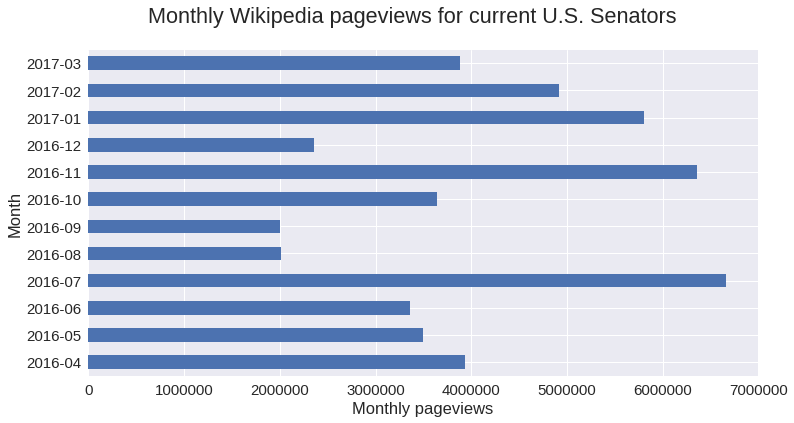

In [16]:
fig = plt.figure()
fig.suptitle("Monthly Wikipedia pageviews for current U.S. Senators")
plt.ticklabel_format(style = 'plain')

ax = sen_monthly_sum.plot(kind='barh', figsize=[12,6])
ax.set_xlabel("Monthly pageviews")
ax.set_ylabel("Month")


### The House

We do the same thing for the House of Representatives, only with different variables. Recall that ```house_list``` is our list of titles:

In [17]:
house_list[0:5]

['Bradley Byrne', 'Martha Roby', 'Mike Rogers', 'Robert Aderholt', 'Mo Brooks']

In [18]:
house_views = p.article_views(project='en.wikipedia', 
                              articles=house_list, 
                              granularity='monthly', 
                              start='2016040100', 
                              end='2017033123')
                              
house_df = pd.DataFrame(house_views)
house_df.ix[0:5, 0:5]

,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00
Adam_Kinzinger,6579.0,10515.0,12002.0,7217.0,22613.0
Adam_Schiff,6541.0,6649.0,12993.0,7501.0,4760.0
Adam_Smith_(politician),2712.0,2400.0,2770.0,2939.0,2458.0
Adrian_Smith_(politician),1368.0,1295.0,1285.0,1151.0,1432.0
Adriano_Espaillat,1296.0,1061.0,5591.0,5360.0,1729.0


In [19]:
house_df = house_df.transpose()
house_df = house_df.set_index(house_df.index.strftime("%Y-%m")).sort_index()
house_df.ix[0:5, 0:5]

,Adam_Kinzinger,Adam_Schiff,Adam_Smith_(politician),Adrian_Smith_(politician),Adriano_Espaillat
2016-04,6579.0,6541.0,2712.0,1368.0,1296.0
2016-05,10515.0,6649.0,2400.0,1295.0,1061.0
2016-06,12002.0,12993.0,2770.0,1285.0,5591.0
2016-07,7217.0,7501.0,2939.0,1151.0,5360.0
2016-08,22613.0,4760.0,2458.0,1432.0,1729.0


In [20]:
house_sum = house_df.sum()
house_sum[0:5]

Adam_Kinzinger               162674.0
Adam_Schiff                  406908.0
Adam_Smith_(politician)       40274.0
Adrian_Smith_(politician)     19851.0
Adriano_Espaillat             67980.0
dtype: float64

In [21]:
house_monthly_sum = house_df.transpose().sum()
house_monthly_sum

2016-04    1727960.0
2016-05    1940369.0
2016-06    1983199.0
2016-07    3009143.0
2016-08    1644636.0
2016-09    1609682.0
2016-10    2558133.0
2016-11    5095820.0
2016-12    2408666.0
2017-01    4190713.0
2017-02    3905450.0
2017-03    5931667.0
dtype: float64

In [22]:
house_monthly_sum.sum()

36005438.0

This gives us 36 million total pageviews for House reps.

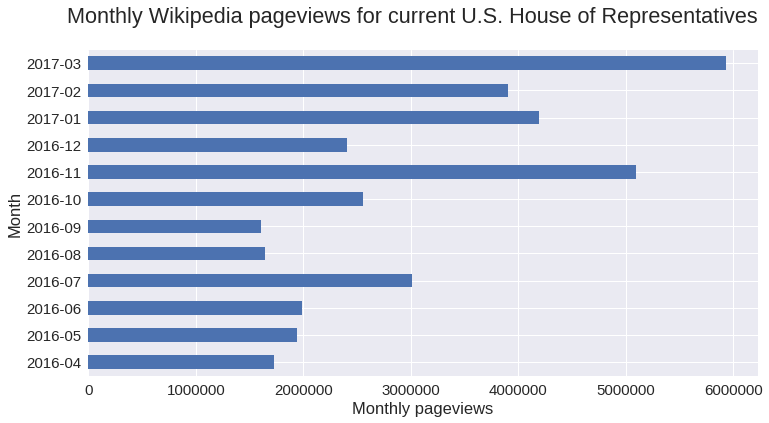

In [23]:
fig = plt.figure()
fig.suptitle("Monthly Wikipedia pageviews for current U.S. House of Representatives")
plt.ticklabel_format(style = 'plain')

ax = house_monthly_sum.plot(kind='barh', figsize=[12,6])
ax.set_xlabel("Monthly pageviews")
ax.set_ylabel("Month")


## Combining the datasets

We have to transpose each dataset back, then append one to the other:

In [24]:
congress_df = house_df.transpose().append(sen_df.transpose())
congress_df.ix[0:10,0:10]

,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Adam_Kinzinger,6579.0,10515.0,12002.0,7217.0,22613.0,6846.0,6869.0,19077.0,14200.0,18531.0
Adam_Schiff,6541.0,6649.0,12993.0,7501.0,4760.0,5068.0,8318.0,13906.0,17191.0,20320.0
Adam_Smith_(politician),2712.0,2400.0,2770.0,2939.0,2458.0,2802.0,2841.0,4745.0,3301.0,5510.0
Adrian_Smith_(politician),1368.0,1295.0,1285.0,1151.0,1432.0,1363.0,2004.0,2292.0,1481.0,1967.0
Adriano_Espaillat,1296.0,1061.0,5591.0,5360.0,1729.0,2754.0,2017.0,11937.0,4421.0,15559.0
Al_Green_(politician),4527.0,3047.0,3243.0,3141.0,2028.0,2878.0,2915.0,3549.0,2382.0,6651.0
Al_Lawson,30.0,36.0,34.0,68.0,479.0,1070.0,1185.0,3856.0,2326.0,4971.0
Alan_Lowenthal,2164.0,2151.0,2575.0,1760.0,1597.0,1455.0,2278.0,3401.0,1985.0,3135.0
Albio_Sires,2348.0,2126.0,2467.0,1960.0,1679.0,3582.0,2483.0,4875.0,1993.0,3175.0
Alcee_Hastings,4795.0,5958.0,5533.0,9017.0,4581.0,4075.0,4711.0,6982.0,3866.0,8475.0


In [25]:
congress_monthly_sum = congress_df.sum()
congress_monthly_sum

2016-04     5659069.0
2016-05     5433877.0
2016-06     5341813.0
2016-07     9671048.0
2016-08     3657626.0
2016-09     3610524.0
2016-10     6205694.0
2016-11    11457053.0
2016-12     4761391.0
2017-01     9993997.0
2017-02     8818326.0
2017-03     9813986.0
dtype: float64

Then to find the total pageviews, run sum on the sum. This is 84.4 million pageviews from March 2016 to March 2017 for all U.S. Members of Congress:

In [26]:
congress_monthly_sum.sum()

84424404.0

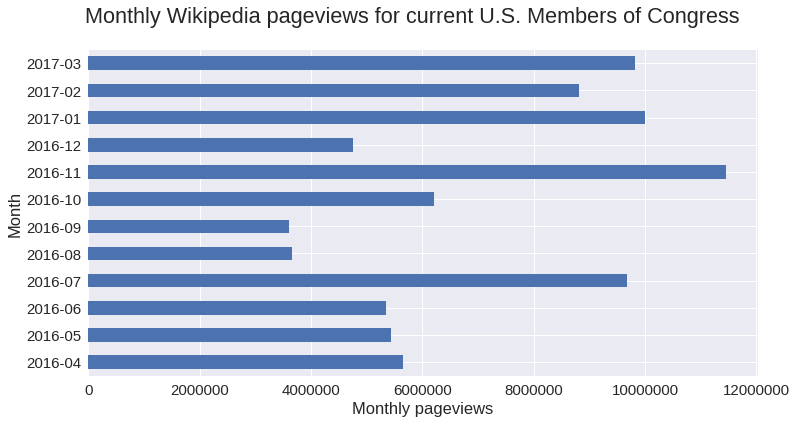

In [27]:
fig = plt.figure()
fig.suptitle("Monthly Wikipedia pageviews for current U.S. Members of Congress")
plt.ticklabel_format(style = 'plain')

ax = congress_monthly_sum.plot(kind='barh', figsize=[12,6])

ax.set_xlabel("Monthly pageviews")
ax.set_ylabel("Month")



## Plotting a single page's views over time

We can query the dataframe by index for a specific page, then plot it:

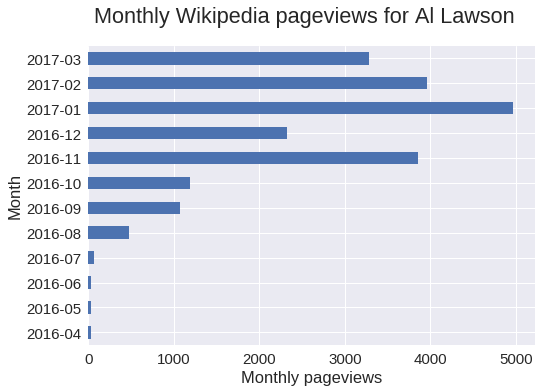

In [31]:
fig = plt.figure()
fig.suptitle("Monthly Wikipedia pageviews for Al Lawson")
plt.ticklabel_format(style = 'plain')

ax = congress_df.ix['Al_Lawson'].plot(kind='barh')

ax.set_xlabel("Monthly pageviews")
ax.set_ylabel("Month")

## Output data

We will export these to a folder called data, in csv and excel formats:

In [32]:
house_df.to_csv("data/house_views.csv")
house_df.to_excel("data/house_views.xlsx")

sen_df.to_csv("data/senate_views.csv")
sen_df.to_excel("data/senate_views.xlsx")

## Old code for trying to programatically get lists of members of Congress

In [33]:
# used to stop "Restart and run all" execution 

assert False is True

AssertionError: 

In [ ]:
site = pywikibot.Site(code="en")
site.login()

In [ ]:
rep_page = pywikibot.Page(site, title="List_of_United_States_Representatives_in_the_115th_Congress_by_seniority")

In [ ]:
rep_list = []
for page in rep_page.linkedPages():
    has_from_cat = False
    has_births_cat = False
    #print(page.title())
    for category in page.categories():
        #print("\t", category.title())
        if category.title().find("Category:Members of the United States House of Representatives from") >= 0:
            has_from_cat = True
        if category.title().find("births") >= 0:
            has_births_cat = True
        if has_births_cat & has_from_cat:
            rep_list.append(page.title())
            break

In [ ]:
senate_list = []
for page in rep_page.linkedPages():
    has_from_cat = False
    has_births_cat = False
    #print(page.title())
    for category in page.categories():
        #print("\t", category.title())
        if category.title().find("United States Senators") >= 0:
            has_from_cat = True
        if category.title().find("births") >= 0:
            has_births_cat = True
        if has_from_cat:
            senate_list.append(page.title())
            break
            